# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

pd.set_option('precision', 2)

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets

my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs

btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price

btc_response = requests.get(btc_url).json()
print(json.dumps(btc_response, indent=4, sort_keys=True))

# Fetch current ETH price

eth_response = requests.get(eth_url).json()
print(json.dumps(eth_response, indent=4, sort_keys=True))

# Compute current value of my crypto

my_btc_value = my_btc * btc_response['data']['1']['quotes']['USD']['price']
my_eth_value = my_eth * eth_response['data']['1027']['quotes']['USD']['price']
print(my_eth_value)

# Print current crypto wallet balance
print(f"\nThe current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"\nThe current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

{
    "data": {
        "1": {
            "circulating_supply": 19107018,
            "id": 1,
            "last_updated": 1659128075,
            "max_supply": 21000000,
            "name": "Bitcoin",
            "quotes": {
                "USD": {
                    "market_cap": 457274258799,
                    "percent_change_1h": 0.168499718430518,
                    "percent_change_24h": -0.760615210208798,
                    "percent_change_7d": 3.35954965877999,
                    "percentage_change_1h": 0.168499718430518,
                    "percentage_change_24h": -0.760615210208798,
                    "percentage_change_7d": 3.35954965877999,
                    "price": 23933.0,
                    "volume_24h": 42332996172
                }
            },
            "rank": 1,
            "symbol": "BTC",
            "total_supply": 19107018,
            "website_slug": "bitcoin"
        }
    },
    "metadata": {
        "error": null,
        "num_cryptocurrenc

### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Instantiate REST API Connection
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

In [8]:
# Format current date as ISO format

today = pd.Timestamp("2022-07-27", tz="America/New_York").isoformat()

# Set the tickers

tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API

timeframe = "1D"

# Get current closing prices for SPY and AGG

agg_spy_closing_df = api.get_bars(
    tickers,
    timeframe,
    start=today,
    end=today
).df

# Reorganize the DataFrame

# Separate ticker data

AGG = agg_spy_closing_df[agg_spy_closing_df['symbol']=='AGG'].drop('symbol', axis=1)
SPY = agg_spy_closing_df[agg_spy_closing_df['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames

ticker_df = pd.concat([AGG, SPY], axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame

ticker_df.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2022-07-27 04:00:00+00:00  103.19  103.64  103.18  103.32  5098243   

                                                  SPY                          \
                          trade_count    vwap    open    high     low   close   
timestamp                                                                       
2022-07-27 04:00:00+00:00       18390  103.36  394.43  402.88  394.05  401.04   

                                                         
                             volume trade_count    vwap  
timestamp                                                
2022-07-27 04:00:00+00:00  81319074      587430  398.31

In [9]:
# Pick AGG and SPY close prices

agg_close_price = AGG['close'].item()
spy_close_price = SPY['close'].item()
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $103.32
Current SPY closing price: $401.04


In [10]:
# Compute the current value of shares

my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares

print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")


The current value of your 200 AGG shares is $20664.00
The current value of your 50 SPY shares is $20052.00


### Savings Health Analysis

In [11]:
# Set monthly household income

monthly_income = 12000

# Consolidate financial assets data
# Create savings DataFrame

total_portfolio = {'Amount': [my_btc_value + my_eth_value, my_agg_value + my_spy_value]}
df_savings = pd.DataFrame(total_portfolio,index=['Crypto','Shares'])

# Display savings DataFrame
df_savings

,Amount
Crypto,37889.98
Shares,40716.00


array([<AxesSubplot:ylabel='Amount'>], dtype=object)

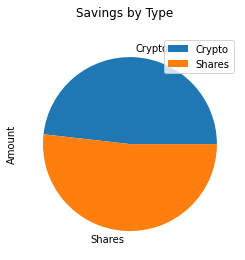

In [12]:
# Plot savings pie chart

df_savings.plot(kind='pie', subplots=True, title='Savings by Type')

In [13]:
# Set ideal emergency fund

emergency_fund = monthly_income * 3

# Calculate total amount of savings

total_savings = df_savings.sum().item()

# Validate saving health
percent_saved = (emergency_fund+total_savings)/total_savings*100

if total_savings > emergency_fund:
    print(f"Great job! You have saved {percent_saved:.2f}% of your intended emergency fund!")
elif total_savings == emergency_fund:
    print(f"You have set and reached your goal! Congratulations!")
else:
    print(f"You are {emergency_fund - total_savings} away from saving for a three month emergency fund.")

Great job! You have saved 145.80% of your intended emergency fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-07-28', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-07-28', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG


df_combined = api.get_bars(tickers, timeframe, start = start_date, end = end_date).df


# Reorganize the DataFrame
# Separate ticker data

AGG5 = df_combined[df_combined['symbol']=='AGG'].drop('symbol', axis=1)
SPY5 = df_combined[df_combined['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames

df_stock_data = pd.concat([AGG5, SPY5], axis=1, keys=['AGG', 'SPY'])

# Display sample data
df_stock_data

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2017-07-28 04:00:00+00:00  109.54  109.70  109.49  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.72  109.58  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.72  109.36  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.77  109.64  109.64  2253372   
2017-08-03 04:00:00+00:00  109.77  109.94  109.74  109.86  1485193   
...                           ...     ...     ...     ...      ...   
2022-07-22 04:00:00+00:00  103.24  103.60  103.11  103.36  6987530   
2022-07-25 04:00:00+00:00  102.90  103.09  102.87  102.98  3577227   
2022-07-26 04:00:00+00:00  103.44  103.51  102.96  102.96  6203148   
2022-07-27 04:00:00+00:00  103.19  103.64  103.18  103.32  5098243   
2022-07-28 04:00:00+00:00  104.09  104.20  103.83  104.06  6473834   

                                                  SPY                          \
                          trade_count    vwap    open    high     low   close   
timestamp                                                                       
2017-07-28 04:00:00+00:00        8841  109.62  246.70  247.06  246.13  246.91   
2017-07-31 04:00:00+00:00       10041  109.67  247.38  247.48  246.53  246.77   
2017-08-01 04:00:00+00:00       10476  109.65  247.45  247.50  246.72  247.32   
2017-08-02 04:00:00+00:00        8484  109.70  247.47  247.60  246.37  247.44   
2017-08-03 04:00:00+00:00        8740  109.83  247.31  247.34  246.64  246.96   
...                               ...     ...     ...     ...     ...     ...   
2022-07-22 04:00:00+00:00       19520  103.27  398.92  400.18  392.75  395.09   
2022-07-25 04:00:00+00:00       15169  102.96  395.72  396.47  393.21  395.57   
2022-07-26 04:00:00+00:00       17921  103.18  393.84  394.06  389.95  390.89   
2022-07-27 04:00:00+00:00       18390  103.36  394.43  402.88  394.05  401.04   
2022-07-28 04:00:00+00:00       23665  104.02  401.84  406.80  398.15  406.07   

                                                         
                             volume trade_count    vwap  
timestamp                                                
2017-07-28 04:00:00+00:00  50088359      168056  246.71  
2017-07-31 04:00:00+00:00  65838659      164615  246.89  
2017-08-01 04:00:00+00:00  55050401      151132  247.20  
2017-08-02 04:00:00+00:00  47211216      178076  247.11  
2017-08-03 04:00:00+00:00  40855997      143604  247.08  
...                             ...         ...     ...  
2022-07-22 04:00:00+00:00  71735015      525110  395.95  
2022-07-25 04:00:00+00:00  53336510      437463  395.05  
2022-07-26 04:00:00+00:00  52767480      436591  391.86  
2022-07-27 04:00:00+00:00  81319074      587430  398.31  
2022-07-28 04:00:00+00:00  73966563      570079  403.64  

[1259 rows x 14 columns]

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns

MC_thirty_yr = MCSimulation(portfolio_data = df_stock_data, weights =[.40, .60], num_simulation = 100, num_trading_days = 252*30)

In [17]:
# Printing the simulation input data

MC_thirty_yr.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2017-07-28 04:00:00+00:00  109.54  109.70  109.49  109.70  1894332   
2017-07-31 04:00:00+00:00  109.69  109.72  109.58  109.65  2362989   
2017-08-01 04:00:00+00:00  109.38  109.72  109.36  109.72  2338876   
2017-08-02 04:00:00+00:00  109.71  109.77  109.64  109.64  2253372   
2017-08-03 04:00:00+00:00  109.77  109.94  109.74  109.86  1485193   

                                                               SPY          \
                          trade_count    vwap daily_return    open    high   
timestamp                                                                    
2017-07-28 04:00:00+00:00        8841  109.62          NaN  246.70  247.06   
2017-07-31 04:00:00+00:00       10041  109.67    -4.56e-04  247.38  247.48   
2017-08-01 04:00:00+00:00       10476  109.65     6.38e-04  247.45  247.50   
2017-08-02 04:00:00+00:00        8484  109.70    -7.29e-04  247.47  247.60   
2017-08-03 04:00:00+00:00        8740  109.83     2.01e-03  247.31  247.34   

                                                                         \
                              low   close    volume trade_count    vwap   
timestamp                                                                 
2017-07-28 04:00:00+00:00  246.13  246.91  50088359      168056  246.71   
2017-07-31 04:00:00+00:00  246.53  246.77  65838659      164615  246.89   
2017-08-01 04:00:00+00:00  246.72  247.32  55050401      151132  247.20   
2017-08-02 04:00:00+00:00  246.37  247.44  47211216      178076  247.11   
2017-08-03 04:00:00+00:00  246.64  246.96  40855997      143604  247.08   

                                        
                          daily_return  
timestamp                               
2017-07-28 04:00:00+00:00          NaN  
2017-07-31 04:00:00+00:00    -5.67e-04  
2017-08-01 04:00:00+00:00     2.23e-03  
2017-08-02 04:00:00+00:00     4.85e-04  
2017-08-03 04:00:00+00:00    -1.94e-03

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns

MC_thirty_yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,0.99,1.00,1.00,1.00,1.01,1.00,1.02,1.01,1.01,0.99,...,1.00,1.00,0.98,1.00,1.00,1.00,1.00,0.99,1.00,1.00
2,1.00,1.01,0.99,1.00,1.00,0.99,1.02,1.03,1.00,0.99,...,1.01,0.99,0.99,1.01,1.00,1.00,1.00,0.99,1.01,1.01
3,1.00,1.01,1.00,0.99,1.01,0.99,1.02,1.03,1.00,0.98,...,1.01,0.99,1.01,1.01,1.00,1.00,0.99,0.99,1.02,1.00
4,1.01,1.02,0.99,0.98,1.00,0.97,1.02,1.03,1.01,0.98,...,1.01,0.98,1.01,1.00,1.00,1.01,0.99,0.99,1.01,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,12.30,6.63,10.16,4.73,10.04,1.05,6.51,2.92,2.55,5.17,...,4.36,4.46,13.01,5.71,26.56,7.26,6.88,12.26,6.43,6.14
7557,12.24,6.66,10.23,4.67,10.00,1.05,6.48,2.95,2.56,5.10,...,4.40,4.43,13.15,5.74,26.44,7.33,6.85,12.28,6.37,6.19
7558,12.41,6.66,10.22,4.58,10.07,1.06,6.42,2.95,2.55,5.14,...,4.37,4.43,13.09,5.80,26.71,7.32,6.78,12.26,6.35,6.20
7559,12.39,6.69,10.17,4.66,10.08,1.07,6.37,2.95,2.56,5.14,...,4.33,4.46,13.09,5.85,26.95,7.31,6.78,12.25,6.35,6.12


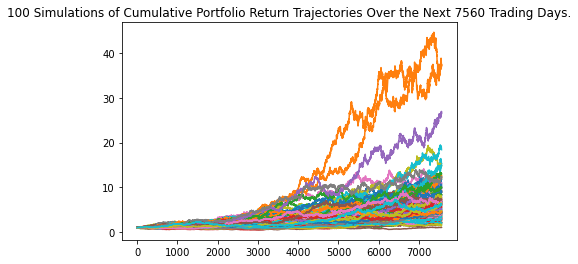

In [19]:
# Plot simulation outcomes

line_plot = MC_thirty_yr.plot_simulation()

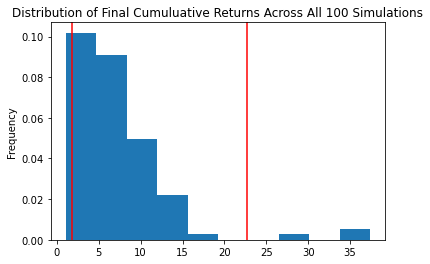

In [20]:
# Plot probability distribution and confidence intervals

dist_plot = MC_thirty_yr.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results

table = MC_thirty_yr.summarize_cumulative_return()

# Print summary statistics

table

count           100.00
mean              7.33
std               5.87
min               1.07
25%               4.11
50%               6.24
75%               8.97
max              37.39
95% CI Lower      1.84
95% CI Upper     22.74
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000

ci_lower = round(table[8] * initial_investment, 2)
ci_upper = round(table[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $36710.21 and $454746.62


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000

ci_lower = round(table[8] * initial_investment, 2)
ci_upper = round(table[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $55065.32 and $682119.93


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

NameError: name 'ci_lower_five' is not defined

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")